# Helmholtz Equation

\begin{equation}
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + k^2 u - q(x,y) = 0,
\end{equation}
with the forcing term:
\begin{equation}
q(x,y) = -\left( a_1 \pi \right)^2 \sin(a_1 \pi x) \sin(a_2 \pi y) - \left( a_2 \pi \right)^2 \sin(a_1 \pi x) \sin(a_2 \pi y) + k \sin(a_1 \pi x) \sin(a_2 \pi y),  \; a_1 = 1.0, \, a_2 = 2.0, \, k=1.0 
\end{equation}

The analytical solution:
\begin{equation}
u(x,y) = \sin(a_1 \pi x) \sin(a_2 \pi y)
\end{equation}

With boundary conditions:
\begin{equation}
u(-1,y) = u(1,y) = u(x,-1) = u(x,1) = 0.
\end{equation}


## 0. Import Library and Generate train-set

In [1]:
from models.torch_relukan import ReLUKANLayer, ReLUKAN
from models.torch_hrkan import HRKANLayer, HRKAN
from models.Bayes_ReLUKAN import Bayes_ReLUKAN
import torch
import matplotlib.pyplot as plt
from torch import autograd
import torch.nn as nn
import numpy as np
import pkbar
from loss_utils import Gaussian_likelihood
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
import time
import random

alpha = 0.05
beta = 0.001
dim = 2
np_i = 256
np_b = 256
ranges = [-1, 1]
a1 = 1.0
a2 = 2.0
k = 1.0

### We will need to do a call to this function in each cell to continually set the seeds in a notebook
# we will only do it for the aleatoric training
def set_seeds_(seed=752022):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)


print("Setting seeds")
set_seeds_()

def batch_jacobian(func, x, create_graph=False,first_call=False):
    def _func_sum(x):
        y = func(x)
        return y.sum(dim=0)
        
    def func_sum_2(x):
        y,_ = func(x)
        return y.sum(dim=0)

    if first_call:
        u = func(x)
        y_jacobian = autograd.functional.jacobian(_func_sum, x, create_graph=create_graph)
        return y_jacobian.permute(1, 0, 2)[:, 0, :],u

    else:
        _,u = func(x)
        y_jacobian = autograd.functional.jacobian(func_sum_2, x, create_graph=create_graph)
        return y_jacobian.permute(1,0,2)[:,:,:],u


def batch_jacobian_aleatoric(func, x, create_graph=False, first_call=False):
    def _func_sum_y(x):
        y = func(x)[0]
        return y.sum(dim=0)
        
    if first_call:
        # Get intitial values of the predictions, and aleatoric
        u, alea = func(x)
        # First order derivatives
        y_jacobian = autograd.functional.jacobian(_func_sum_y, x, create_graph=create_graph)
        return y_jacobian.permute(1, 0, 2)[:, 0, :], u, alea
    else:
        # Second call get the aleatoric and predictions from first call
        _,u,alea = func(x)
        # Second order derivatives
        y_jacobian = autograd.functional.jacobian(_func_sum_y, x, create_graph=create_graph)
        return y_jacobian.permute(1, 0, 2)[:,:,:], u, alea

# define solution
sigma=0.1
sol_fun = lambda x: torch.sin(a1*torch.pi*x[:,[0]])*torch.sin(a2*torch.pi*x[:,[1]]) + torch.abs(x[:,[0]])*torch.tensor(np.random.normal(loc=0,scale=sigma,size=x[:,[0]].shape),device=x.device)
source_fun = lambda x: -(a1*torch.pi)**2 * torch.sin(a1*torch.pi*x[:,[0]])*torch.sin(a2*torch.pi*x[:,[1]]) -(a2*torch.pi)**2 * torch.sin(a1*torch.pi*x[:,[0]])*torch.sin(a2*torch.pi*x[:,[1]]) + k*torch.sin(a1*torch.pi*x[:,[0]])*torch.sin(a2*torch.pi*x[:,[1]]) + torch.abs(x[:,[0]])*torch.tensor(np.random.normal(loc=0,scale=sigma,size=x[:,[0]].shape),device=x.device)
noise_fun = lambda x: torch.abs(x[:,[0]])*torch.tensor(np.random.normal(loc=0,scale=sigma,size=x[:,[0]].shape),device=x.device)

# interior
sampling_mode = 'random'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

Setting seeds


## 1. Generate test-set

In [2]:
print("Setting seeds")
set_seeds_()

sampling_mode_test = 'mesh'

x_test_mesh = torch.linspace(ranges[0],ranges[1],steps=100)
y_test_mesh = torch.linspace(ranges[0],ranges[1],steps=100)
X_test, Y_test = torch.meshgrid(x_test_mesh, y_test_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_test_i = torch.stack([X_test.reshape(-1,), Y_test.reshape(-1,)]).permute(1,0)
else:
    #random
    x_test_i = torch.rand((np_i**2,2))*2-1
    
xb1_test = helper(X_test[0], Y_test[0])
xb2_test = helper(X_test[-1], Y_test[0])
xb3_test = helper(X_test[:,0], Y_test[:,0])
xb4_test = helper(X_test[:,0], Y_test[:,-1])
x_test_b = torch.cat([xb1_test, xb2_test, xb3_test, xb4_test], dim=0)

X_test_np = X_test.clone().detach().numpy()
Y_test_np = Y_test.clone().detach().numpy()
x_test = torch.stack([X_test.reshape(-1,), Y_test.reshape(-1,)]).permute(1,0)
sol = sol_fun(x_test)

Setting seeds


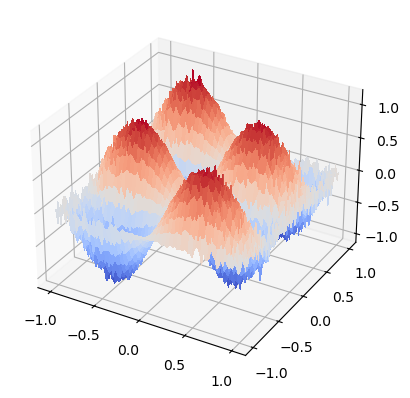

In [3]:
fig,ax = plt.subplots(1,1,subplot_kw={"projection": "3d"})
ax.plot_surface(X_test_np,Y_test_np,sol.reshape(X_test_np.shape),cmap=cm.coolwarm,antialiased=False)
plt.show()

## 2. Check if have GPU and move data there

In [4]:
print("Setting seeds")
set_seeds_()

if torch.cuda.is_available():
    x_i = x_i.cuda()
    x_b = x_b.cuda()
    x_test = x_test.cuda()
    x_test_i = x_test_i.cuda()
    x_test_b = x_test_b.cuda()

Setting seeds


## 3. Function to Train Bayesian (H)ReLU-KAN

In [5]:
print("Setting seeds")
set_seeds_()

def train_bkan(model,num_epochs):
    opt = torch.optim.Adam(model.parameters())

    plt.ion()
    losses = []
    pde_losses = []
    bc_losses = []
    pde_losses_test = []
    bc_losses_test = []
    l2_losses_test = []
    l2_losses_std_test= []

    start = time.time()
    epoch = 0
    alpha=1.0
    gamma = 1.0
    kbar = pkbar.Kbar(target=num_epochs, epoch=epoch, num_epochs=num_epochs, width=20, always_stateful=False)
    for epoch in range(num_epochs):
        if (epoch % 10000 == 0) and (epoch > 0) and (epoch != num_epochs - 10000):
            print(" ")
            print("Reseting optimizer at epoch ",epoch)
            opt = torch.optim.Adam(model.parameters())
            print(" ")
            
        if (epoch % 10000 == 0) and (epoch == num_epochs - 10000):
            print(" ")
            print("Reseting optimizer at epoch ",epoch,". Decreasing learning rate")
            opt = torch.optim.Adam(model.parameters(),lr=0.0001)
            print(" ")
        
        opt.zero_grad()

        # Interior
        sol_D1_fun = lambda x: batch_jacobian_aleatoric(model, x, create_graph=True,first_call=True)
        sol_D2,u,sigma_D2 = batch_jacobian_aleatoric(sol_D1_fun, x_i, create_graph=True)
        lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
        source = source_fun(x_i)
        pde_loss,pde_mse = Gaussian_likelihood(lap + k**2 * u,sigma_D2,source)

        # Boundary Conditions
        bc_true = sol_fun(x_b)   
        bc_pred,bc_log_devs2 = model(x_b)
        bc_loss,bc_mse = Gaussian_likelihood(bc_pred,bc_log_devs2,bc_true)


        kl_div_ = beta * model.kl_div()
        pde = alpha * pde_loss
        loss = pde + gamma * bc_loss + kl_div_
        loss.backward()
        opt.step()

        with torch.no_grad():
            sol_D2_test,u_test,sigma_D2_test = batch_jacobian_aleatoric(sol_D1_fun, x_test_i, create_graph=False)
            lap_test = torch.sum(torch.diagonal(sol_D2_test, dim1=1, dim2=2), dim=1, keepdim=True)
            source_test = source_fun(x_test_i)
            pde_loss_test,test_pde_mse = Gaussian_likelihood(lap_test + k**2 * u_test,sigma_D2_test,source_test)


            bc_true_test = sol_fun(x_test_b)          
            bc_pred_test,bc_logdevs2_test = model(x_test_b)
            bc_loss_test,test_bc_mse = Gaussian_likelihood(bc_pred_test,bc_logdevs2_test,bc_true_test)
    
            l2_test = torch.mean((model(x_test)[0].cpu() - sol)**2)
            l2_test_std = torch.std((model(x_test)[0].cpu() - sol)**2)

            test_kl_ = beta * model.kl_div()
            test_loss_ = alpha * pde_loss_test + bc_loss_test + test_kl_

                

            pde_losses.append(pde_loss.cpu().detach().numpy())
            bc_losses.append(bc_loss.cpu().detach().numpy())
            pde_losses_test.append(pde_loss_test.cpu().detach().numpy())
            bc_losses_test.append(bc_loss_test.cpu().detach().numpy())
            l2_losses_test.append(l2_test.cpu().detach().numpy())
            l2_losses_std_test.append(l2_test_std.cpu().detach().numpy())

        kbar.update(epoch,values=[("loss", loss.item()),('mse',pde_mse.item()),("kl_div",kl_div_.item()),("pde",pde.item()),("bc",bc_loss.item()),("test_loss",test_loss_.item())])

    elapsed = (time.time() - start)

    with torch.no_grad():
        output,epistemic,aleatoric_ = model.sample(x_test,num_samples=5000)
        output = output.cpu().clone().detach().numpy().reshape(X_test_np.shape)
        epistemic = epistemic.cpu().clone().detach().numpy().reshape(X_test_np.shape)
        aleatoric_ = aleatoric_.cpu().clone().detach().numpy().reshape(X_test_np.shape)

    return output, losses, pde_losses, bc_losses, pde_losses_test, bc_losses_test, l2_losses_test, l2_losses_std_test, elapsed,epistemic,aleatoric_


Setting seeds


## 4. Define the function to train ReLUKAN and HRKAN

In [6]:
print("Setting seeds")
set_seeds_()

def train_model(model,num_epochs):

    opt = torch.optim.Adam(model.parameters())

    plt.ion()
    losses = []
    pde_losses = []
    bc_losses = []
    pde_losses_test = []
    bc_losses_test = []
    l2_losses_test = []
    l2_losses_std_test= []

    start = time.time()
    epoch = 0
    kbar = pkbar.Kbar(target=num_epochs, epoch=epoch, num_epochs=num_epochs, width=20, always_stateful=False)
    for epoch in range(num_epochs):
        opt.zero_grad()

        sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True,first_call=True)#[:,0,:]
        sol_D2,u = batch_jacobian(sol_D1_fun, x_i, create_graph=True)#[:,:,:]
        lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
        source = source_fun(x_i)
        pde_loss = torch.mean((lap + k**2 * u - source)**2)

        bc_true = sol_fun(x_b)
        bc_pred = model(x_b)
        bc_loss = torch.mean((bc_pred-bc_true)**2)

        loss = alpha * pde_loss + bc_loss
        loss.backward()
        opt.step()

        with torch.no_grad():

            sol_D2_test,u_test = batch_jacobian(sol_D1_fun, x_test_i, create_graph=False)#[:,:,:]
            lap_test = torch.sum(torch.diagonal(sol_D2_test, dim1=1, dim2=2), dim=1, keepdim=True)
            source_test = source_fun(x_test_i)
            pde_loss_test = torch.mean((lap_test + k**2 * u_test - source_test)**2)
    
            bc_true_test = sol_fun(x_test_b)
            bc_pred_test = model(x_test_b)
            bc_loss_test = torch.mean((bc_pred_test-bc_true_test)**2)
    
            l2_test = torch.mean((model(x_test).cpu() - sol)**2)
            l2_test_std = torch.std((model(x_test).cpu() - sol)**2)
    
            pde_losses.append(pde_loss.cpu().detach().numpy())
            bc_losses.append(bc_loss.cpu().detach().numpy())
            pde_losses_test.append(pde_loss_test.cpu().detach().numpy())
            bc_losses_test.append(bc_loss_test.cpu().detach().numpy())
            l2_losses_test.append(l2_test.cpu().detach().numpy())
            l2_losses_std_test.append(l2_test_std.cpu().detach().numpy())

        kbar.update(epoch,values=[("loss", loss.item())])

    elapsed = (time.time() - start)

    with torch.no_grad():
        output = model(x_test).cpu().clone().detach().numpy().reshape(X_test_np.shape)
    
    return output, losses, pde_losses, bc_losses, pde_losses_test, bc_losses_test, l2_losses_test, l2_losses_std_test, elapsed

Setting seeds


## 5. Define the function to plot ground-truth solution, learnt solutions and their residual difference

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
print("Setting seeds")
set_seeds_()

def plot_fig(relu_kan_, hrkan_, bkan_, output_folder='PDE'):
    label_size = 25
    labelpad = 15
    tick_size2 = 18
    fig, axs = plt.subplots(2, 4, figsize=(26, 13), subplot_kw={"projection": "3d"})
    fig.delaxes(axs[1, 0])
    plt.tight_layout()
    
    # true solution
    surf1 = axs[0, 0].plot_surface(X_test_np, Y_test_np, sol.reshape(X_test_np.shape), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[0, 0].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[0, 0].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[0, 0].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[0, 0].set_title('Ground-truth + Noise', fontsize=label_size)
    
    # RELU_KAN
    surf2 = axs[0, 1].plot_surface(X_test_np, Y_test_np, relu_kan_[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[0, 1].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[0, 1].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[0, 1].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[0, 1].set_title('ReLU-KAN Solution', fontsize=label_size)
    
    surf3 = axs[1, 1].plot_surface(X_test_np, Y_test_np, (sol.reshape(X_test_np.shape) - relu_kan_[0]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[1, 1].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[1, 1].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[1, 1].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[1, 1].set_title('ReLU-KAN Residual', fontsize=label_size)
    
    # HRKAN
    surf4 = axs[0, 2].plot_surface(X_test_np, Y_test_np, hrkan_[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[0, 2].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[0, 2].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[0, 2].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[0, 2].set_title('HRKAN Solution', fontsize=label_size)
    
    surf5 = axs[1, 2].plot_surface(X_test_np, Y_test_np, (sol.reshape(X_test_np.shape) - hrkan_[0]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[1, 2].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[1, 2].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[1, 2].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[1, 2].set_title('HRKAN Residual', fontsize=label_size)
    
    # KAN
    surf6 = axs[0, 3].plot_surface(X_test_np, Y_test_np, bkan_[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[0, 3].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[0, 3].zaxis.set_major_formatter('{x:.01f}')
    axs[0, 3].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[0, 3].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[0, 3].set_zlabel('u(x,y)', fontsize=label_size,labelpad=labelpad)
    axs[0, 3].set_title('Bayes-HRKAN Solution', fontsize=label_size)
    
    surf7 = axs[1, 3].plot_surface(X_test_np, Y_test_np, (sol.reshape(X_test_np.shape) - bkan_[0]), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    axs[1, 3].set_zticks([-1.0,-0.5,0,0.5,1.0])
    axs[1, 3].zaxis.set_major_formatter('{x:.01f}')
    axs[1, 3].set_xlabel('x', fontsize=label_size,labelpad=labelpad)
    axs[1, 3].set_ylabel('y', fontsize=label_size,labelpad=labelpad)
    axs[1, 3].set_zlabel('u(x,y)', fontsize=label_size,labelpad=labelpad)
    axs[1, 3].set_title('Bayes-HRKAN Residual', fontsize=label_size)

    for ax in axs.flat:
        ax.tick_params(axis='both', which='major', labelsize=14,pad=0)  # Adjust for x and y axes
        ax.tick_params(axis='z', which='major', labelsize=14,pad=9)     # Adjust for z axis (if 3D)


    for k in range(4):  # Assuming 4 subplots per row
        if k < 3:  # For all but the last subplot in the row
            axs[0, k].tick_params(axis='z', labelleft=False)  # Hide z-axis labels in the first row
            axs[1, k].tick_params(axis='z', labelleft=False) 
        
    plt.subplots_adjust(hspace=0.0)
    cb1 = fig.colorbar(surf1, ax=axs, orientation='vertical')
    cb1.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb1.ax.tick_params(labelsize=20)
    plt.savefig(os.path.join(output_folder, f'Helmholtz_fig.pdf'), bbox_inches="tight")
    plt.close()

    # Second figure
    fig = plt.figure(figsize=(25, 6))
    ax1 = fig.add_subplot(141)#, projection='3d')
    ax2 = fig.add_subplot(142)#, projection='3d')
    ax3 = fig.add_subplot(143)#, projection='3d')
    ax4 = fig.add_subplot(144)

    max_ = np.max(np.abs(sol.reshape(X_test_np.shape) - bkan_[0]).cpu().numpy())
    
    # Plot first surface
    surf_epi = ax1.pcolormesh(X_test_np, Y_test_np, bkan_[-2], shading='auto', cmap='seismic')
    surf_epi.set_clim(0,max_)
    ax1.set_xticks([-1.0, -0.5, 0, 0.5, 1.0])
    ax1.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
    ax1.set_xlabel('x', fontsize=label_size, labelpad=labelpad-12)
    ax1.set_ylabel('y', fontsize=label_size, labelpad=labelpad-5)
    ax1.set_title('Bayes-HRKAN Epistemic', fontsize=label_size)
    
    # Create colorbar for the first subplot
    cb1_ax = fig.add_axes([0.13, -0.03, 0.16, 0.02])  # [left, bottom, width, height]
    cb2 = fig.colorbar(surf_epi, cax=cb1_ax, orientation='horizontal')
    cb2.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb2.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb2.ax.tick_params(labelsize=20)
    cb2.set_label('Epistemic Uncertainty', fontsize=label_size,labelpad=10)
    

    # Plot second surface
    surf_alea = ax2.pcolormesh(X_test_np,Y_test_np,bkan_[-1],shading='auto',cmap='seismic')
    surf_alea.set_clim(0,max_)
    ax2.set_yticks([])
    ax2.set_xlabel('x', fontsize=label_size, labelpad=labelpad-12)
    ax2.set_title('Bayes-HRKAN Aleatoric', fontsize=label_size)
    
    # Create colorbar for the first subplot
    cb2_ax = fig.add_axes([0.332, -0.03, 0.16, 0.02])
    cb3 = fig.colorbar(surf_alea, cax=cb2_ax, orientation='horizontal')
    cb3.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb3.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb3.ax.tick_params(labelsize=20)
    cb3.set_label('Aleatoric Uncertainty', fontsize=label_size,labelpad=10)
    
    # Plot third surface
    surf_abs = ax3.pcolormesh(X_test_np,Y_test_np,np.abs(sol.reshape(X_test_np.shape) - bkan_[0]),shading='auto',cmap='seismic')
    surf_abs.set_clim(0,max_)
    ax3.set_yticks([])
    ax3.set_xlabel('x', fontsize=label_size, labelpad=labelpad-12)
    ax3.set_title('Bayes-HRKAN Absolute Error', fontsize=label_size)
    
    # Create colorbar for the second subplot
    cb3_ax = fig.add_axes([0.535, -0.03, 0.16, 0.02])
    cb4 = fig.colorbar(surf_abs, cax=cb3_ax, orientation='horizontal')
    cb4.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb4.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb4.ax.tick_params(labelsize=20)
    cb4.set_label('Absolute Error', fontsize=label_size,labelpad=10)


    f = noise_fun(x_test.clone().detach().cpu()).reshape(X_test_np.shape)
    # Plot noise
    surf_noise = ax4.pcolormesh(X_test_np,Y_test_np,np.abs(f),shading='auto',cmap='seismic')
    surf_noise.set_clim(0,max_)
    ax4.set_yticks([])
    ax4.set_xlabel('x', fontsize=label_size, labelpad=labelpad-12)
    ax4.set_title('True Aleatoric Component', fontsize=label_size)
    
    # Create colorbar for the second subplot
    cb4_ax = fig.add_axes([0.738, -0.03, 0.16, 0.02])
    cb5 = fig.colorbar(surf_noise, cax=cb4_ax, orientation='horizontal')
    cb5.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb5.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cb5.ax.tick_params(labelsize=20)
    cb5.set_label('Aleatoric Component', fontsize=label_size,labelpad=10)

    ax1.tick_params(axis='both', which='major', labelsize=tick_size2)  
    ax2.tick_params(axis='x', which='major', labelsize=tick_size2)
    ax3.tick_params(axis='x', which='major', labelsize=tick_size2)
    ax4.tick_params(axis='x',which='major',labelsize=tick_size2)

    
    # Adjust layout
    plt.subplots_adjust(wspace=0.2)  # Adjust the spacing as needed
    plt.savefig(os.path.join(output_folder, f'Helmholtz_epistemic.pdf'), bbox_inches="tight")
    plt.close()

## 7. Define the function to calculate MSE, MSE std. and training time

In [ ]:
print("Setting seeds")
set_seeds_()

def cal_error(relu_kan_, hrkan_,bkan_):
    relu_kan_loss.append([alpha * x + y for x, y in zip(relu_kan_[2], relu_kan_[3])])
    relu_kan_loss_test.append([alpha * x + y for x, y in zip(relu_kan_[4], relu_kan_[5])])
    relu_kan_L2s.append(relu_kan_[-3])
    relu_kan_L2s_std.append(relu_kan_[-2])
    relu_kan_time.append(relu_kan_[-1])
    hrkan_loss.append([alpha * x + y for x, y in zip(hrkan_[2], hrkan_[3])])
    hrkan_loss_test.append([alpha * x + y for x, y in zip(hrkan_[4], hrkan_[5])])
    hrkan_L2s.append(hrkan_[-3])
    hrkan_L2s_std.append(hrkan_[-2])
    hrkan_time.append(hrkan_[-1])
    bkan_loss.append([x + y for x, y in zip(bkan_[2], bkan_[3])])
    bkan_loss_test.append([x + y for x, y in zip(bkan_[4], bkan_[5])])
    bkan_L2s.append(bkan_[-5])
    bkan_L2s_std.append(bkan_[-4])
    bkan_time.append(bkan_[-3])

## 8. Train the models

In [19]:
net = Bayes_ReLUKAN([2,2,1], 10, 3, imin=-1, imax=1,aleatoric=True,multi_dim=True,order=4)
t_params = sum(p.numel() for p in net.parameters())
print("Network Parameters: ",t_params)

Aleatoric surrogate model using same structure as functional KAN.
Using higher order Bayesian ReLU-KAN.
Network Parameters:  5219


In [13]:
net

Bayes_ReLUKAN(
  (rk_layers): ModuleList(
    (0): Bayes_ReLUKANLayer(
      (equal_size_conv): MNFConv2d(
        (flow_q): NormalizingFlow(
          (flows): ModuleList(
            (0-1): 2 x RNVP(
              (net): MLP(
                (0): Linear(in_features=2, out_features=50, bias=True)
              )
              (t): Linear(in_features=50, out_features=2, bias=True)
              (s): Linear(in_features=50, out_features=2, bias=True)
            )
          )
        )
        (flow_r): NormalizingFlow(
          (flows): ModuleList(
            (0-1): 2 x RNVP(
              (net): MLP(
                (0): Linear(in_features=2, out_features=50, bias=True)
              )
              (t): Linear(in_features=50, out_features=2, bias=True)
              (s): Linear(in_features=50, out_features=2, bias=True)
            )
          )
        )
      )
    )
    (1): Bayes_ReLUKANLayer(
      (equal_size_conv): MNFConv2d(
        (flow_q): NormalizingFlow(
          (flow

In [ ]:
print("Setting seeds")
set_seeds_()

relu_kan_preds = []
hrkan_preds = []
bkan_preds = []
relu_kan_loss, relu_kan_loss_test, relu_kan_L2s, relu_kan_L2s_std, relu_kan_time = [], [], [], [], []
hrkan_loss, hrkan_loss_test, hrkan_L2s, hrkan_L2s_std, hrkan_time = [], [], [], [], []
bkan_loss, bkan_loss_test, bkan_L2s, bkan_L2s_std, bkan_time = [], [], [], [], []

num_epochs_bkan= 60000
num_epochs = 60000
output_folder = "Helmholtz_Results"


if not os.path.exists(output_folder):
    print(" ")
    print("Outputs will be placed in " + str(output_folder))
    os.makedirs(output_folder)


torch.cuda.empty_cache()
bkan = Bayes_ReLUKAN([2,2,1], 10, 3, imin=-1, imax=1,aleatoric=True,multi_dim=True,order=4)
bkan = bkan.cuda()
bkan_results = train_bkan(bkan,num_epochs_bkan)
torch.cuda.empty_cache() 
bkan_preds.append(bkan_results[0])
del bkan

print(" ")
relu_kan = ReLUKAN([2,2,1], 10, 3, -1, 1)
relu_kan = relu_kan.cuda()
relu_kan_results = train_model(relu_kan,num_epochs)
relu_kan_preds.append(relu_kan_results[0])   
del relu_kan

print(" ")
hrkan = HRKAN([2,2,1], 10, 3, -1, 1, 4)
hrkan = hrkan.cuda()
hrkan_results = train_model(hrkan,num_epochs)
hrkan_preds.append(hrkan_results[0])
del hrkan


plot_fig(relu_kan_results, hrkan_results,bkan_results,output_folder=output_folder)
cal_error(relu_kan_results, hrkan_results, bkan_results)

## 8. Calculate mean MSE, mean MSE std. and mean training time

In [ ]:
print("Timing information")
print("RELU KAN")
print("{0:.5g}".format(np.asarray(relu_kan_time)[-1]))
print(" ")
print("HRKAN")
print("{0:.5g}".format(np.array(hrkan_time)[-1]))
print(" ")
print("Bayesian HRKAN")
print("{0:.5g}".format(np.array(bkan_time)[-1]))

In [ ]:
bkan_mse  = np.array((bkan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
hrkan_mse = np.array((hrkan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
rkan_mse = np.array((relu_kan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
bkan_mse_std = np.std((bkan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
hrkan_mse_std = np.std((hrkan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
rkan_mse_std = np.std((relu_kan_preds[0] - sol.reshape(X_test_np.shape).numpy())**2)
    
    
print("RELU KAN")
print("Average mse: ",np.mean(rkan_mse), "std: ",rkan_mse_std)
print(" ")
print("HRKAN")
print("Average mse: ",np.mean(hrkan_mse), "std: ",hrkan_mse_std)
print(" ")
print("Bayesian HRKAN")
print("Average mse: ",np.mean(bkan_mse), "std: ",bkan_mse_std)

print("Average Aleatoric: ",bkan_results[-1].mean())
print("Std Aleatoric: ",bkan_results[-1].std())
print("Average Epistemic: ",bkan_results[-2].mean())
print("Std Epistemic: ",bkan_results[-2].std())
print("Average rmse: ",np.sqrt(np.average(bkan_mse)))